In [1]:
from matplotlib import pyplot as plt
import numpy as np

from metrics.mot_ground_truth_assigner import MOTGroundTruthAssigner
from models.ocsort_utils.metric_utils import iou_batch


print(plt.rcParams["figure.figsize"])

[6.4, 4.8]


In [2]:
class PrecomputedMOTTracker():

    def __init__(self, seq_path=None):
        self.seq_dets = np.loadtxt(seq_path, delimiter=',')
        
        self.last_frame = int(self.seq_dets[:, 0].max())
    
    def __call__(self, frame):
        tracks = self.seq_dets[self.seq_dets[:, 0] == frame, :]
        return tracks

In [3]:
def center(tracks):
    cx = tracks[..., 0] + (tracks[..., 2] / 2.0)
    cy = tracks[..., 1] + (tracks[..., 3] / 2.0)

    return cx, cy

def compute_iou(tracks1, tracks2):
    xx1 = np.maximum(tracks1[..., 0], tracks2[..., 0])
    yy1 = np.maximum(tracks1[..., 1], tracks2[..., 1])
    xx2 = np.minimum(tracks1[..., 0] + tracks1[..., 2], tracks2[..., 0] + tracks2[..., 2])
    yy2 = np.minimum(tracks1[..., 1] + tracks1[..., 3], tracks2[..., 1] + tracks2[..., 3])

    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)

    intersection_area_matrix = w * h

    area_test = tracks1[..., 2] * tracks1[..., 3]
    area_gt = tracks2[..., 2] * tracks2[..., 3]

    union_area_matrix = (area_test + area_gt - intersection_area_matrix)

    iou = intersection_area_matrix / union_area_matrix

    return iou

In [4]:

gt_tracker = PrecomputedMOTTracker('./DATA/output_4_gt.txt')
#tracker = PrecomputedMOTTracker('./OUTPUT/ocsort_tracking_output_4_kalman.txt')
#tracker = PrecomputedMOTTracker('./OUTPUT/output_4_dets_pca.txt')
tracker = PrecomputedMOTTracker('./OUTPUT/output_4_kalman_pca.txt')

In [5]:
iou_batch_dist = lambda bb_test, bb_gt : 1 - iou_batch(bb_test, bb_gt)
tracks_assigner = MOTGroundTruthAssigner(iou_batch_dist, 0.5)

gt_tck_angle_diff = []
gt_tck_angle_err = []
gt_tck_mod_diff = []
gt_tck_iou = []

previous_assigments = np.empty((0, 2), dtype=int)
lost_gt_tracks = dict() # To keep info about gt that has an ID but now are free

id_sw = 0
frag = 0
tp = 0
fp = 0
fn = 0

for frame in range(1, gt_tracker.last_frame + 1):

    gt_tracks = gt_tracker(frame)
    tracks = tracker(frame)
    prev_tracks = tracker(frame - 1)

    assigments = tracks_assigner(gt_tracks, tracks) # IDs gt, IDs tck

    tp += len(assigments)
    fp += len(tracks) - len(assigments)
    fn += len(gt_tracks) - len(assigments)

    # Speed of tracks and gt_tracks
    for gt, tck in assigments:

        gt_tck_iou.extend(compute_iou(gt_tracks[gt_tracks[:, 1] == gt, 2:6], tracks[tracks[:, 1] == tck, 2:6]))

        if tck in set(prev_tracks[:, 1]):
            origin_track = np.array(center(prev_tracks[prev_tracks[:, 1] == tck, 2:6]))
            gt_track = np.array(center(gt_tracks[gt_tracks[:, 1] == gt, 2:6]))
            pred_track = np.array(center(tracks[tracks[:, 1] == tck, 2:6]))
            
            o_gt = gt_track - origin_track
            m_o_gt = np.linalg.norm(o_gt) + np.finfo(o_gt.dtype).eps
            a_o_gt = (np.pi / 2 -  np.arccos(o_gt[0, 0] / m_o_gt)) * 180 / np.pi * (1. if o_gt[1, 0] >= 0 else -1.)
            
            o_tck = pred_track - origin_track
            m_o_tck = np.linalg.norm(o_tck) + np.finfo(o_tck.dtype).eps
            a_o_tck_rad = np.pi / 2 - np.arccos(o_tck[0, 0] / m_o_tck) * (1. if o_tck[1, 0] >= 0 else -1.)
            a_o_tck = a_o_tck_rad * 180 / np.pi

            a_err_o_tck = np.arccos(np.dot(o_tck.T, o_gt)[0, 0] / (m_o_tck * m_o_gt)) * 180 / np.pi

            gt_tck_angle_diff.append(a_o_tck - a_o_gt if np.abs(a_o_tck - a_o_gt) <= 180 else a_o_tck - a_o_gt + 360 * (1. if a_o_gt > a_o_tck else -1.))
            gt_tck_mod_diff.append(m_o_tck - m_o_gt)
            gt_tck_angle_err.append(a_err_o_tck)

    # ID switch, Fragmentations, TP, FP, FN
    for gt, tck in previous_assigments:
        if gt in set(assigments[:, 0]):
            if tck != assigments[assigments[:, 0] == gt, 1]:
                id_sw += 1
        else:
            frag += 1
            lost_gt_tracks[gt] = tck
    
    for gt, tck in assigments:
        if gt in set(lost_gt_tracks.keys()):
            if lost_gt_tracks[gt] != tck:
                id_sw += 1
            del lost_gt_tracks[gt]

    previous_assigments = assigments

mota = 1 - (fn + fp + id_sw) / len(gt_tracker.seq_dets)
motp = float(np.sum(gt_tck_iou) / (tp + np.finfo(float).eps))

print(f'{id_sw=}\n{frag=}\n{tp=}\n{fp=}\n{fn=}\n{mota=:.02f}\n{motp=:.02f}')



id_sw=81
frag=4202
tp=16624
fp=12973
fn=13769
mota=0.12
motp=0.65


Text(0.5, 1.0, 'angle error')

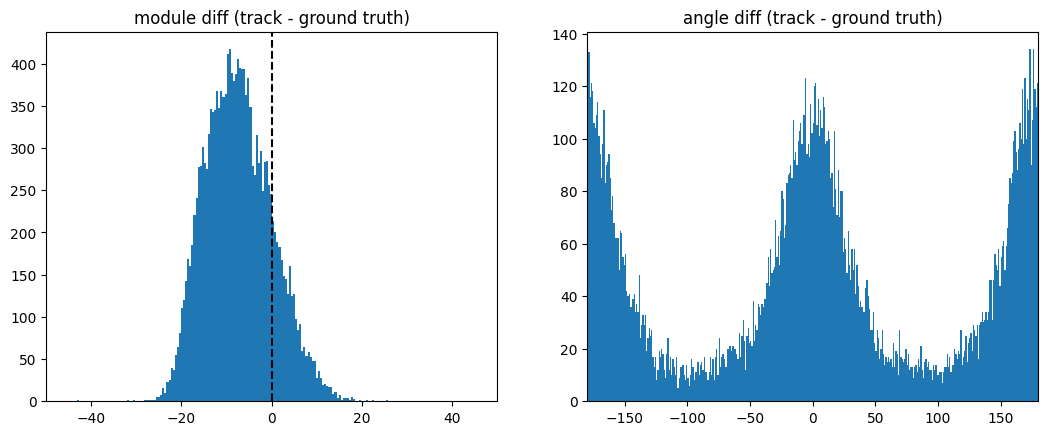

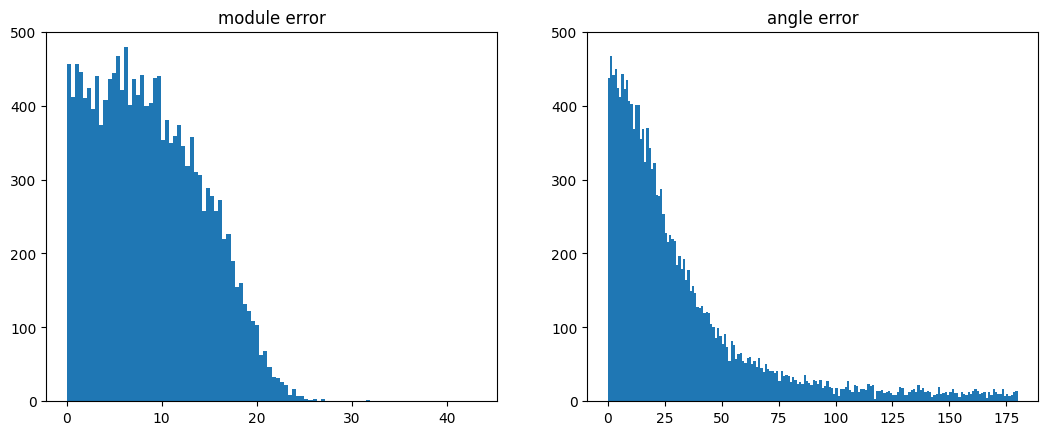

In [6]:
plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(gt_tck_mod_diff, bins=150)
plt.axvline(0, linestyle='--', color='k')
plt.xlim(-50, 50)
plt.title('module diff (track - ground truth)')

plt.subplot(1, 2, 2)
plt.hist(gt_tck_angle_diff, bins=360)
plt.xlim(-180, 180)
plt.title('angle diff (track - ground truth)')

# Absolute values
plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.ylim(0, 500)
plt.hist(np.abs(np.asarray(gt_tck_mod_diff)), bins=100)
plt.title('module error')

#gt_tck_angle_err = np.abs(np.asarray(gt_tck_angle_diff))

plt.subplot(1, 2, 2)
plt.ylim(0, 500)
plt.hist(gt_tck_angle_err, bins=180)
plt.title('angle error')

Text(0.5, 1.0, 'IoU (track - ground truth)')

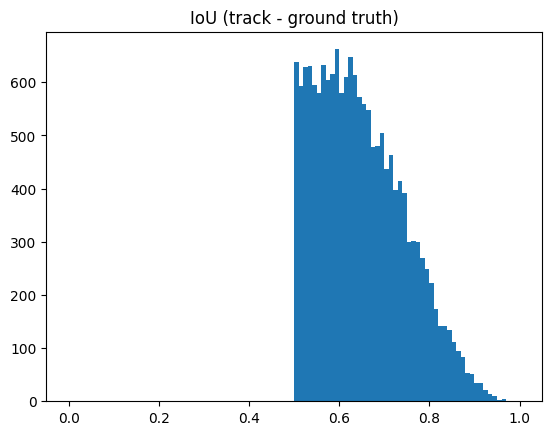

In [7]:
plt.hist(gt_tck_iou, bins=100, range=[0, 1])
plt.title('IoU (track - ground truth)')
